In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch.nn as nn
import cv2
import torchvision.transforms as T
from torchinfo import summary
from torch.optim import Adam
import torchvision.ops as ops

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os
notebook_dir= os.path.dirname(os.path.abspath("__file__"))
project_root= os.path.abspath(os.path.join(notebook_dir, '..'))

src_path= os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
from config import data_dir, images_train_dir, images_val_dir, labels_train_dir, labels_val_dir, artifacts_dir
import config
from preprocessing import FaceDataset, generate_anchor_boxes, filter_valid_bboxes, calculate_iou
from utils import draw_image_with_box, visualize_anchors_and_gt

In [3]:
valid_img_extensions= ('.jpg', '.jpeg', '.png')
all_images= [
    img for img in os.listdir(images_train_dir)
    if img.lower().endswith(valid_img_extensions) and os.path.exists(os.path.join(labels_train_dir, img.rsplit('.', 1)[0] + ".txt"))
]
all_images[1:5]

['998faa48943fce6f.jpg',
 'a228f997057aa291.jpg',
 '49fe432784afea63.jpg',
 '0106e273d2de08be.jpg']

In [4]:
train_images, val_images= train_test_split(all_images, test_size= 0.2, random_state= 42)
transforms= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir, image_list= train_images, max_boxes= 10, transform= transforms)
train_dataset[1]['image'].shape

torch.Size([3, 224, 224])

In [5]:
sample_image= train_dataset[5]['image']
sample_label= train_dataset[5]['boxes']

In [6]:
resnet= models.resnet50(pretrained= True)
resnet_backbone= nn.Sequential(*list(resnet.children())[:-4])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
feature_maps= resnet_backbone(sample_image.unsqueeze(0))
feature_maps.shape

torch.Size([1, 512, 28, 28])

In [8]:
def generate_anchor_centers(feature_map_shape):
    fm_height, fm_width= feature_map_shape

    y, x= np.mgrid[0:fm_height, 0:fm_width]
    centers= np.stack([x.ravel(), y.ravel()], axis= 1)
    return centers

In [9]:
feature_maps.shape[-2:]

torch.Size([28, 28])

In [10]:
anc_ctrs= generate_anchor_centers(feature_maps.shape[-2:])
anc_ctrs

array([[ 0,  0],
       [ 1,  0],
       [ 2,  0],
       ...,
       [25, 27],
       [26, 27],
       [27, 27]])

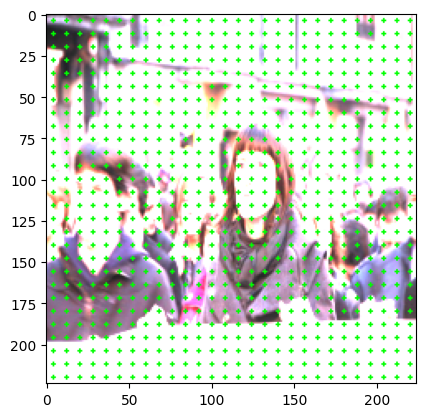

In [11]:
image_height, image_width= sample_image.shape[-2:]
fm_height, fm_width= feature_maps.shape[-2:]
stride= image_height // fm_height

anc_ctrs_fm= generate_anchor_centers(feature_maps.shape[-2:])

ctrs_img_proj= (anc_ctrs_fm + 0.5) * stride 
ctrs_img_proj

np_image = sample_image.detach().cpu().numpy()
np_image = np.transpose(np_image, (1, 2, 0))  # Convert [C, H, W] to [H, W, C]
image_width, image_height= np_image.shape[:2]

if np_image.max() > 1.0:
    np_image= np_image / 255.0

np_image= np.clip(np_image, 0.0, 1.0)
np_image = (np_image * 255).astype(np.uint8)  # Scale to [0, 255]
if not np_image.flags['C_CONTIGUOUS']:
    np_image= np.ascontiguousarray(np_image)

for cx, cy in ctrs_img_proj:
    cv2.circle(np_image, (int(cx), int(cy)), 1, (0, 255, 0), -1)
plt.imshow(np_image)
plt.show()

In [12]:
anchor_scales= [2, 4, 8, 16, 24, 32, 64]
anchor_ratios= [0.25, 0.45, 0.55, 1, 1.3, 2]
stride= 6
num_anchors_per_loc= len(anchor_scales) * len(anchor_ratios)
def generate_anchors(feature_map_shape, anchor_scales, anchor_ratios,
                     stride, num_anchors_per_location):
    anchor_base_wh= []
    for scale in anchor_scales:
        area= scale * scale
        for ratio in anchor_ratios:
            width= np.sqrt(area * ratio)
            height= np.sqrt(area / ratio)
            anchor_base_wh.append((width, height))
    
    fm_height, fm_width= feature_map_shape
    # Get centers in feature map space
    y_feature_map, x_feature_map= np.mgrid[0:fm_height, 0:fm_width]
    centers_x_fm= x_feature_map.ravel()
    centers_y_fm= y_feature_map.ravel()
    
    # Get centers in image space
    centers_x_img= (centers_x_fm + 0.5) * stride
    centers_y_img= (centers_y_fm + 0.5) * stride
    
    # Repeat for all anchors per location
    centers_x_img= np.repeat(centers_x_img, num_anchors_per_location)
    centers_y_img= np.repeat(centers_y_img, num_anchors_per_location)
    
    # Create width-height pairs for each of the anchor types
    width_height_per_anchor= np.tile(anchor_base_wh, (fm_height * fm_width, 1))

    # Build anchor boxes
    anchor_width, anchor_height= width_height_per_anchor[:, 0], width_height_per_anchor[:, 1]
    x1= centers_x_img - anchor_width / 2.0
    y1= centers_y_img - anchor_height / 2.0
    x2= centers_x_img + anchor_width / 2.0
    y2= centers_y_img + anchor_height / 2.0

    x1= np.clip(x1, 0, 255)
    y1= np.clip(y1, 0, 255)
    x2= np.clip(x2, 0, 255)
    y2= np.clip(y2, 0, 255)
    anchors= np.stack([x1, y1, x2, y2], axis= 1)
    anchors_tensor= torch.tensor(anchors, dtype= torch.float32)
    return anchors_tensor


In [13]:
all_anchors= generate_anchors((28, 28), anchor_scales,
                          anchor_ratios, stride, num_anchors_per_loc)
all_anchors.shape

torch.Size([32928, 4])

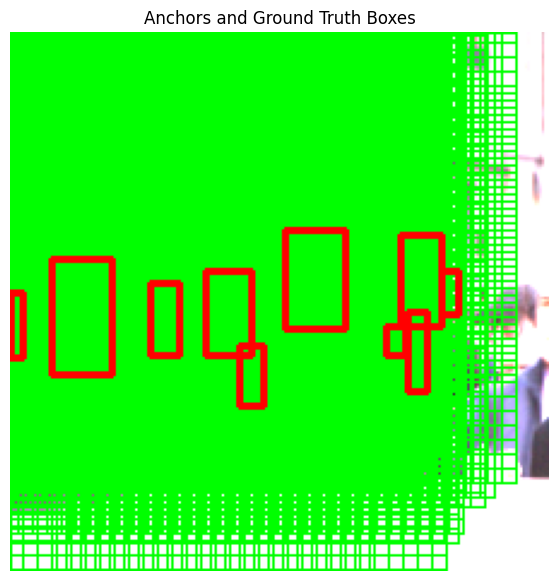

In [14]:
visualize_anchors_and_gt(sample_image, all_anchors, sample_label)

In [15]:
filtered_boxes= filter_valid_bboxes(sample_label)
filtered_boxes

tensor([[  0., 108.,   5., 135.],
        [ 17.,  94.,  42., 142.],
        [ 58., 104.,  70., 134.],
        [ 81.,  99., 100., 134.],
        [ 95., 130., 105., 155.],
        [114.,  82., 139., 123.],
        [156., 122., 164., 134.],
        [162.,  84., 179., 122.],
        [165., 116., 173., 149.],
        [179.,  99., 186., 117.]])

In [16]:
all_anchors.shape, filtered_boxes.shape

(torch.Size([32928, 4]), torch.Size([10, 4]))

In [17]:
def calculate_ious(anchor_boxes, gt_boxes, eps: float= 1e-6):
    # Get areas
    anchor_areas= (anchor_boxes[:, 2] - anchor_boxes[:, 0]) * (anchor_boxes[:, 3] - anchor_boxes[:, 1])
    gt_areas= (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])
    # Get intersection info
    top_left_intersection= torch.maximum(anchor_boxes[:, None, :2], gt_boxes[None, :, :2])
    right_bottom_intersection= torch.minimum(anchor_boxes[:, None, 2:], gt_boxes[None, :, 2:])
    width_height_intersection= torch.clamp(right_bottom_intersection - top_left_intersection, min= 0)
    inter_area= width_height_intersection[:, :, 0] * width_height_intersection[:, :, 1]
    # Union
    union= anchor_areas[:, None] + gt_areas[None, :] - inter_area
    # IOU
    iou= inter_area / (union + eps)
    return iou

In [18]:
iou_matrix= calculate_ious(all_anchors, filtered_boxes)
iou_matrix.shape

torch.Size([32928, 10])

In [19]:
def analyze_iou_distribution(anchor_boxes, gt_boxes):
    iou_matrix = ops.box_iou(all_anchors, filtered_boxes)
    max_ious = iou_matrix.max(dim=1)[0]
    
    print("IoU Distribution:")
    print(f"  > 0.7: {(max_ious > 0.7).sum()}")
    print(f"  > 0.5: {(max_ious > 0.5).sum()}")
    print(f"  > 0.3: {(max_ious > 0.3).sum()}")
    print(f"  > 0.1: {(max_ious > 0.1).sum()}")
    print(f"  = 0.0: {(max_ious == 0.0).sum()}")
analyze_iou_distribution(all_anchors, filtered_boxes)

IoU Distribution:
  > 0.7: 10
  > 0.5: 123
  > 0.3: 940
  > 0.1: 5652
  = 0.0: 20653


In [20]:
# 1. Check coordinate ranges
print("anchors min / max:", all_anchors.min(), all_anchors.max())
print("gt_boxes min / max:", filtered_boxes.min(), filtered_boxes.max())

# 2. Count how many anchors are fully inside 0-223
inside = ((all_anchors[:, 0] >= 0) & (all_anchors[:, 1] >= 0) &
          (all_anchors[:, 2] <= 223) & (all_anchors[:, 3] <= 223))
print("anchors fully inside image:", inside.sum().item())

anchors min / max: tensor(0.) tensor(229.)
gt_boxes min / max: tensor(0.) tensor(186.)
anchors fully inside image: 32900


In [ ]:
def match_anchors_to_gt(
        anchors,
        gt_boxes,
        iou_high_threshold: float = 0.6,
        iou_low_threshold: float = 0.3,
        num_samples: int = 256,
        pos_ratio: float = 0.5,
        anchors_per_gt: int = 16,
        device: torch.device = None
):
    if device is None:
        device = anchors.device

    num_anchors = anchors.shape[0]
    num_gt = gt_boxes.shape[0]

    iou = calculate_iou(anchors, gt_boxes)

    labels = torch.full((num_anchors,), -1, dtype=torch.long, device=device)

    # Foreground: for each GT pick its best anchors (up to anchors_per_gt)
    for gt_id in range(num_gt):
        gt_iou = iou[:, gt_id]
        cand = torch.where(gt_iou >= iou_high_threshold)[0]
        if cand.numel() == 0:                       # no anchor meets threshold
            cand = torch.tensor([gt_iou.argmax()], device=device)    # fall back to best
        if cand.numel() > anchors_per_gt:
            cand = cand[torch.randperm(cand.numel())[:anchors_per_gt]]
        labels[cand] = 1

    # Background
    bg_mask = (iou < iou_low_threshold).all(dim=1)
    labels[bg_mask] = 0

    # Global balanced sampling (unchanged)
    pos_target = int(num_samples * pos_ratio)
    neg_target = num_samples - pos_target

    pos_inds = torch.where(labels == 1)[0]
    if len(pos_inds) > 0:
        for idx in pos_inds:
            max_iou_for_this_anchor = iou[idx].max()
            
            # Check if this anchor meets threshold OR is a fallback assignment
            meets_threshold = max_iou_for_this_anchor >= iou_high_threshold
            
            # Check if this is a fallback case (best anchor for some GT)
            is_fallback = False
            for gt_id in range(num_gt):
                gt_iou = iou[:, gt_id]
                if gt_iou.argmax() == idx and (gt_iou >= iou_high_threshold).sum() == 0:
                    is_fallback = True
                    break
            
            assert meets_threshold or is_fallback, f"Bug: anchor {idx} has max IoU {max_iou_for_this_anchor:.3f} < {iou_high_threshold} and is not a fallback"
    neg_inds = torch.where(labels == 0)[0]

    if len(pos_inds) > pos_target:
        perm = torch.randperm(len(pos_inds), device=device)[:pos_target]
        pos_inds = pos_inds[perm]
    if len(neg_inds) > neg_target:
        perm = torch.randperm(len(neg_inds), device=device)[:neg_target]
        neg_inds = neg_inds[perm]

    keep = torch.cat([pos_inds, neg_inds])
    labels = labels[keep]

    best_gt_per_anchor = iou.argmax(dim=1)
    gt_assign = best_gt_per_anchor[keep]
    return keep, labels, gt_assign

In [22]:
keep, labels, gt_assign= match_anchors_to_gt(all_anchors, filtered_boxes)

In [23]:
foreground_mask= labels == 1
pos_anchor_idx= keep[foreground_mask]
pos_anchor_idx

tensor([19687, 19688, 19689, 19729, 19730, 19731, 20863, 20864, 20865, 20905,
        20906, 20907, 21158, 21367, 21368, 21830, 22543, 22544, 22585, 22586,
        22782, 22783, 22784, 22789, 22957, 22958, 22999, 23000, 23006, 23538,
        23719, 23720, 23761, 23762, 23959, 23960, 25802, 27031, 27738, 27739,
        27740, 28914])

In [24]:
pos_anchors= all_anchors[pos_anchor_idx]
pos_anchors.shape

torch.Size([42, 4])

In [25]:
pos_gt_idx= gt_assign[foreground_mask]
pos_gt_boxes= filtered_boxes[pos_gt_idx]
pos_gt_boxes.shape

torch.Size([42, 4])

In [26]:
keep, labels, gt_assign = match_anchors_to_gt(all_anchors, filtered_boxes)
foreground_mask = labels == 1
pos_anchor_idx = keep[foreground_mask]
pos_anchors = all_anchors[pos_anchor_idx]
pos_gt_idx = gt_assign[foreground_mask]
pos_gt_boxes = filtered_boxes[pos_gt_idx]

# Calculate IoU between matched positive anchors and their assigned GT boxes
iou_check = calculate_iou(pos_anchors, pos_gt_boxes)
matched_ious = torch.diagonal(iou_check)

print(f"Min IoU of positive pairs: {matched_ious.min():.3f}")
print(f"Max IoU of positive pairs: {matched_ious.max():.3f}")
print(f"Anchors with IoU < 0.1: {(matched_ious < 0.1).sum()}")

Min IoU of positive pairs: 0.436
Max IoU of positive pairs: 0.775
Anchors with IoU < 0.1: 0


In [27]:
# Check if coordinates are valid
print("Sample positive anchor:", pos_anchors[0])
print("Sample GT box:", pos_gt_boxes[0])
print("Anchor areas:", ((pos_anchors[:, 2] - pos_anchors[:, 0]) * (pos_anchors[:, 3] - pos_anchors[:, 1]))[:5])
print("GT areas:", ((pos_gt_boxes[:, 2] - pos_gt_boxes[:, 0]) * (pos_gt_boxes[:, 3] - pos_gt_boxes[:, 1]))[:5])

# Check for invalid boxes
invalid_anchors = (pos_anchors[:, 2] <= pos_anchors[:, 0]) | (pos_anchors[:, 3] <= pos_anchors[:, 1])
invalid_gt = (pos_gt_boxes[:, 2] <= pos_gt_boxes[:, 0]) | (pos_gt_boxes[:, 3] <= pos_gt_boxes[:, 1])
print(f"Invalid anchors: {invalid_anchors.sum()}")
print(f"Invalid GT boxes: {invalid_gt.sum()}")

# Check coordinate ranges
print("Anchor x1, y1, x2, y2 ranges:")
print(f"  x1: {pos_anchors[:, 0].min():.1f} to {pos_anchors[:, 0].max():.1f}")
print(f"  y1: {pos_anchors[:, 1].min():.1f} to {pos_anchors[:, 1].max():.1f}")
print(f"  x2: {pos_anchors[:, 2].min():.1f} to {pos_anchors[:, 2].max():.1f}")
print(f"  y2: {pos_anchors[:, 3].min():.1f} to {pos_anchors[:, 3].max():.1f}")

print("GT x1, y1, x2, y2 ranges:")
print(f"  x1: {pos_gt_boxes[:, 0].min():.1f} to {pos_gt_boxes[:, 0].max():.1f}")
print(f"  y1: {pos_gt_boxes[:, 1].min():.1f} to {pos_gt_boxes[:, 1].max():.1f}")
print(f"  x2: {pos_gt_boxes[:, 2].min():.1f} to {pos_gt_boxes[:, 2].max():.1f}")
print(f"  y2: {pos_gt_boxes[:, 3].min():.1f} to {pos_gt_boxes[:, 3].max():.1f}")

Sample positive anchor: tensor([112.2669,  75.1486, 133.7331, 122.8514])
Sample GT box: tensor([114.,  82., 139., 123.])
Anchor areas: tensor([1023.9999, 1024.0002, 1024.0000, 1023.9999, 1024.0002])
GT areas: tensor([1025., 1025., 1025., 1025., 1025.])
Invalid anchors: 0
Invalid GT boxes: 0
Anchor x1, y1, x2, y2 ranges:
  x1: 0.0 to 157.0
  y1: 75.1 to 131.0
  x2: 7.0 to 176.9
  y2: 115.0 to 163.0
GT x1, y1, x2, y2 ranges:
  x1: 0.0 to 165.0
  y1: 82.0 to 130.0
  x2: 5.0 to 179.0
  y2: 122.0 to 155.0


In [28]:
print("Anchor format:", all_anchors[:5])  # Should be [x1, y1, x2, y2]
print("GT format:", filtered_boxes[:5])   # Should be [x1, y1, x2, y2]
print("Anchor ranges:", all_anchors.min(0)[0], all_anchors.max(0)[0])
print("GT ranges:", filtered_boxes.min(0)[0], filtered_boxes.max(0)[0])

Anchor format: tensor([[2.5000, 1.0000, 3.5000, 5.0000],
        [2.3292, 1.5093, 3.6708, 4.4907],
        [2.2584, 1.6516, 3.7416, 4.3484],
        [2.0000, 2.0000, 4.0000, 4.0000],
        [1.8598, 2.1229, 4.1402, 3.8771]])
GT format: tensor([[  0., 108.,   5., 135.],
        [ 17.,  94.,  42., 142.],
        [ 58., 104.,  70., 134.],
        [ 81.,  99., 100., 134.],
        [ 95., 130., 105., 155.]])
Anchor ranges: tensor([0.0000, 0.0000, 3.5000, 3.7071]) tensor([164.5000, 164.2929, 210.2548, 229.0000])
GT ranges: tensor([  0.,  82.,   5., 117.]) tensor([179., 130., 186., 155.])


In [29]:
# Get the original IoU matrix
iou_matrix = calculate_iou(all_anchors, filtered_boxes)

# For each positive anchor, find its IoU with all GT boxes
for i, anchor_idx in enumerate(pos_anchor_idx[:5]):  # Check first 5
    anchor_ious = iou_matrix[anchor_idx]
    max_iou = anchor_ious.max()
    max_gt_idx = anchor_ious.argmax()
    
    print(f"Anchor {i}: max IoU = {max_iou:.3f} with GT {max_gt_idx}")
    print(f"  IoU with assigned GT {pos_gt_idx[i]}: {anchor_ious[pos_gt_idx[i]]:.3f}")

Anchor 0: max IoU = 0.649 with GT 5
  IoU with assigned GT 5: 0.649
Anchor 1: max IoU = 0.647 with GT 5
  IoU with assigned GT 5: 0.647
Anchor 2: max IoU = 0.641 with GT 5
  IoU with assigned GT 5: 0.641
Anchor 3: max IoU = 0.705 with GT 5
  IoU with assigned GT 5: 0.705
Anchor 4: max IoU = 0.700 with GT 5
  IoU with assigned GT 5: 0.700


In [30]:
# Test IoU calculation
test_box1 = torch.tensor([[0, 0, 10, 10]], dtype=torch.float32)
test_box2 = torch.tensor([[5, 5, 15, 15]], dtype=torch.float32)  # Should have IoU ≈ 0.14
test_iou = calculate_iou(test_box1, test_box2)
print(f"Test IoU: {test_iou.item():.3f}")  # Should be ~0.14

Test IoU: 0.143


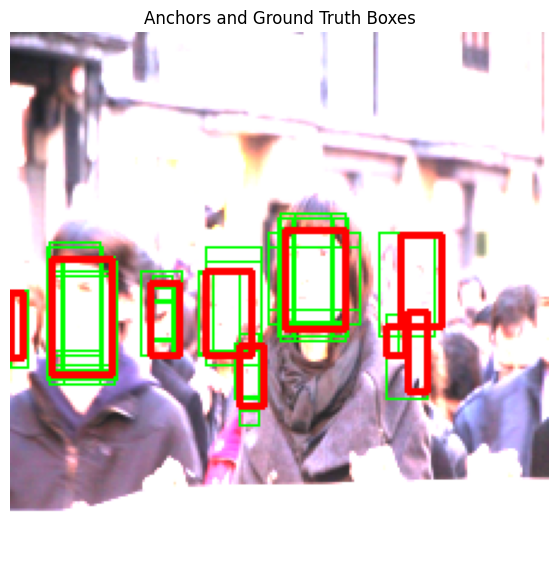

In [31]:
visualize_anchors_and_gt(sample_image, pos_anchors, pos_gt_boxes)

In [32]:
print(all_anchors[:10])          # should be ~[0–223]
print(filtered_boxes[:5])          # should be ~[0–223]

tensor([[2.5000, 1.0000, 3.5000, 5.0000],
        [2.3292, 1.5093, 3.6708, 4.4907],
        [2.2584, 1.6516, 3.7416, 4.3484],
        [2.0000, 2.0000, 4.0000, 4.0000],
        [1.8598, 2.1229, 4.1402, 3.8771],
        [1.5858, 2.2929, 4.4142, 3.7071],
        [2.0000, 0.0000, 4.0000, 7.0000],
        [1.6584, 0.0186, 4.3416, 5.9814],
        [1.5168, 0.3032, 4.4832, 5.6968],
        [1.0000, 1.0000, 5.0000, 5.0000]])
tensor([[  0., 108.,   5., 135.],
        [ 17.,  94.,  42., 142.],
        [ 58., 104.,  70., 134.],
        [ 81.,  99., 100., 134.],
        [ 95., 130., 105., 155.]])


In [33]:
print(calculate_ious(all_anchors, filtered_boxes[:5]).max(dim=1)[0])

tensor([0., 0., 0.,  ..., 0., 0., 0.])
